Analyze the Google drive feedback (exported as tsv in `data/feedback.tsv`) that are embeded at the end of tutorials

In [1]:
!type python

python is /Users/bebatut/miniconda3/envs/galaxy-training-material-stats/bin/python


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from pprint import pprint

# Load the feedback

In [54]:
df = pd.read_csv('../data/feedback.tsv', sep='\t')
# remove last column
df = df.drop(['Make feedback confidential?'], axis=1)
# rename column
df = df.rename(columns = {'Timestamp': 'timestamp',
    'How much did you like this tutorial?': 'note',
    'What did you like?': 'pro',
    'What could be improved?': 'con',
    'Tutorial': 'tutorial_topic'})
# extract topic from tutorial name
new = df.tutorial_topic.str.split('(', n = 1, expand = True) 
df["tutorial"]= new[0] 
df["topic"]= new[1].str[:-1]
df = df.drop(columns =["tutorial_topic"])
# remove rows with NaN on note, pro and con
df = df.dropna(subset=['note', 'pro', 'con'], how='all')
# replace NaN in note by 0
df = df.fillna(value={'note': 0})
# format note to integer
df.note = df.note.astype(int)
# number of rows
len(df)

443

In [53]:
df.head()

,timestamp,note,pro,con,tutorial,topic
0,09/09/2018 12:35:00,4,NaN,the clear instruction pattern,A short introduction to Galaxy,Introduction to Galaxy Analyses
1,11/09/2018 23:03:53,5,very detailed,NaN,A short introduction to Galaxy,Introduction to Galaxy Analyses
2,14/09/2018 21:19:59,5,"very detailed and easy to follow, even for a c...",NaN,Galaxy 101,Introduction to Galaxy Analyses
3,15/09/2018 15:24:55,5,"very detailed and easy to follow, thank you",NaN,Introduction to Genomics and Galaxy,Introduction to Galaxy Analyses
4,15/09/2018 20:09:52,5,That all the tools had helpful explanations,If there was a guide to say which tool to use ...,Galaxy 101,Introduction to Galaxy Analyses


# General stats

In [69]:
df.note.value_counts(sort=False)[1:]

1     22
2     13
3     23
4     93
5    288
Name: note, dtype: int64

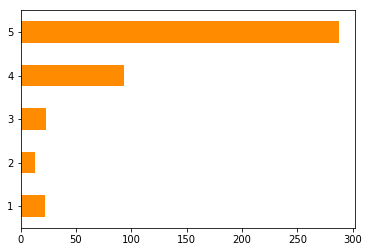

In [71]:
#df.note.plot.hist(color='k')
df.note.value_counts(sort=False)[1:].plot(kind='barh', color='DarkOrange')